<a href="https://colab.research.google.com/github/itsmeeeeeee/MML/blob/main/MMFA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Multimodal Fusion Model with Self-Attention (MMFA) and LSTM Classifier**

In [ ]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from torchvision import models, transforms
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim


In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Text and image Feature are extracted with pretrained Modells BERT and RestNet-50

**Read the data**

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load labels from CSV
file_path_labels = "/content/drive/MyDrive/MultimodalNLP/projekt/data/labels.csv"
labeled_data = pd.read_csv(file_path_labels)
labels = labeled_data['overall_sentiment'].values

# Define your existing mapping
label_mapping = {
    "very_negative": 0,
    "negative": 0,
    "positive": 1,
    "very_positive": 1
}

# Get valid indices for labels that exist in the mapping
valid_indices = [i for i, label in enumerate(labels) if label in label_mapping]
filtered_labels = [labels[i] for i in valid_indices]

# Apply the mapping to convert filtered text labels to numeric labels
numeric_labels = np.array([label_mapping[label] for label in filtered_labels])

# Convert labels to a torch tensor
numeric_labels = torch.tensor(numeric_labels, dtype=torch.long)
print("numeric labels:", numeric_labels.shape)

# Load image features
file_path_im = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/image_features_restnet.npy"
image_features = np.load(file_path_im)

# Load text features
file_path_emb = "/content/drive/MyDrive/MultimodalNLP/projekt/features_data/text_features_bert.npy"
text_features = np.load(file_path_emb)

# Filter image and text features using valid indices
filtered_image_features = torch.tensor(image_features[valid_indices], dtype=torch.float32)
filtered_text_features = torch.tensor(text_features[valid_indices], dtype=torch.float32)

print("Filtered Image features:", filtered_image_features.shape)
print("Filtered Text features:", filtered_text_features.shape)


numeric labels: torch.Size([4791])
Filtered Image features: torch.Size([4791, 1000])
Filtered Text features: torch.Size([4791, 768])


In [ ]:
#print(text_features[1])
#print(image_features[1])

**Split the data**

In [ ]:
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming that 'filtered_text_features', 'filtered_image_features', and 'numeric_labels' are correctly defined as per previous discussions

"""
Split the initial dataset into training and preliminary testing sets.
20% of the data is reserved for preliminary testing, and 80% is used for training.
"""
train_text, prelim_test_text, train_image, prelim_test_image, train_labels, prelim_test_labels = train_test_split(
    filtered_text_features, filtered_image_features, numeric_labels, test_size=0.2, random_state=42
)

"""
Further split the preliminary testing data into validation and final test sets.
40% of the preliminary test data is used for validation and 60% for the final testing.
"""
val_text, test_text, val_image, test_image, val_labels, test_labels = train_test_split(
    prelim_test_text, prelim_test_image, prelim_test_labels, test_size=0.6, random_state=42
)

# Print to check the distribution of labels in the preliminary test set
c_0 = 0
c_1 = 0

for el in prelim_test_labels:
    if el == 1:
        c_1 += 1
    elif el == 0:
        c_0 += 1

print("positive: ", c_1)
print("negative: ", c_0)



positive:  851
negative:  108


**Load the data**

In [ ]:
# Creating DataLoaders for training, validation, and test datasets
train_dataset = TensorDataset(train_text, train_image, train_labels)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(val_text, val_image, val_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(test_text, test_image, test_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

**Self-Attention Block**

In [ ]:
"""
Implementing a self-attention module based on the concept explained in:
https://medium.com/@wangdk93/implement-self-attention-and-cross-attention-in-pytorch-1f1a366c9d4b#d075

"""

class SelfAttention(nn.Module):
    def __init__(self, feature_dim, dropout=0.1):
        super(SelfAttention, self).__init__()

        # Scaling factor to normalize the dot products
        self.scale = 1.0 / (feature_dim ** 0.5)

       # Linear transformations for the query, key, and value vectors
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        #dropout
        #self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Generate query, key, value tensors
        queries = self.query(x.unsqueeze(1))
        keys = self.key(x.unsqueeze(1))
        values = self.value(x.unsqueeze(1))

        # Calculate the attention scores and apply softmax
        scores = torch.bmm(queries, keys.transpose(1, 2)) * self.scale
        attention_weights = F.softmax(scores, dim=-1)
        # dropout
        #attention_weights = self.dropout(attention_weights)

        # Multiply the attention weights by the values
        weighted = torch.bmm(attention_weights, values)
        return weighted.squeeze(1)


**Bi-directional LSTM Classifier**

In [ ]:
"""
Code adapted from this blog: https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#steps
"""

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # For bidirectional LSTM

    def forward(self, x):
        # Initialize hidden and cell states
        # Dimensions: (num_layers * num_directions, batch_size, hidden_size)
        batch_size = x.size(0)  # Get the current batch size
        num_directions = 2 if self.lstm.bidirectional else 1
        h0 = torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers * num_directions, batch_size, self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the last timestep
        return out


**Multimodal Fusion Model**

In [ ]:
"""
Multimodal Fusion Classifier incorporating self-attention for feature fusion.
Adapted and inspired by a GitHub project on multimodal sentiment analysis:
https://github.com/imadhou/multimodal-sentiment-analysis/blob/main/notebooks/multi_modal_model.ipynb

"""

class MultimodalFusionClassifier(nn.Module):
    def __init__(self, text_dim, image_dim, hidden_dim, lstm_hidden_dim, num_classes):
        super(MultimodalFusionClassifier, self).__init__()
        self.text_model = nn.Linear(text_dim, hidden_dim)
        self.image_model = nn.Linear(image_dim, hidden_dim)

        # Self-attention module for refining text and image features by focusing on important elements.
        self.text_attention = SelfAttention(hidden_dim)
        self.image_attention = SelfAttention(hidden_dim)

        # LSTM Classifier
        #self.classifier = LSTMClassifier(hidden_dim, lstm_hidden_dim, num_layers=2, num_classes=num_classes)
        self.classifier = LSTMClassifier(hidden_dim * 2, lstm_hidden_dim, num_layers=2, num_classes=num_classes)

        #self.dropout = nn.Dropout(0.5)


    def forward(self, text_features, image_features):
        # Process text features and give attention
        text_features = self.text_model(text_features)
        text_features = self.text_attention(text_features)

        # Process image features and give attention
        image_features = self.image_model(image_features)
        image_features = self.image_attention(image_features)

        # Combine text and image features
        combined_features = torch.cat([text_features, image_features], dim=1)
        combined_features = combined_features.unsqueeze(1)

        # Apply dropout
        #combined_features = self.dropout(combined_features)

        # Classification
        #The combined features are passed through the LSTM classifier to produce the final output.
        output = self.classifier(combined_features)
        return output


**Initialize the model**

In [ ]:
"""
initialize the model with specidied dimensions and number of classes
text_dim=768: Dimension of text input features
image_dim=1000: Dimension of image input features
hidden_dim=128: Dimension of hidden layers used for processing and integrating features
num_classes=3: Number of output classes for classification
"""

model = MultimodalFusionClassifier(text_dim=768, image_dim=1000, hidden_dim=128,  lstm_hidden_dim=256, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# CrossEntropyLoss is used as the loss function for the classifier
criterion = nn.CrossEntropyLoss()

# ReduceLROnPlateau is used for reducing the learning rate when a metric has stopped improving.
# Here, 'mode' is set to 'min', meaning the scheduler will reduce the learning rate when the monitored quantity stops decreasing.
# The reduction factor is set to 0.1, reducing the learning rate to 10% of its current value when a plateau is reached.

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1)


**Train the model**

In [ ]:
"""
Training and validation loop for a Multimodal Fusion Classifier.
The code for the loop structure is adapted from Sebastian Raschka's guide on training loops in PyTorch:
https://sebastianraschka.com/faq/docs/training-loop-in-pytorch.html

Early stopping implementation inspired by: https://keras.io/api/callbacks/early_stopping/
"""

import torch
import numpy as np

def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, scheduler, patience=10):
    trigger_times = 0  # Counter for the number of times validation loss has not improved
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model_state = None  # To store the best model state

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for texts, images, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients to zero for a new optimization step
            outputs = model(texts, images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()  # Accumulate loss over the epoch

        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for texts, images, labels in val_loader:
                outputs = model(texts, images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        average_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}: Training Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f}')

        #Potentially adjusts the learning rate based on the validation loss.
        scheduler.step(average_val_loss)

        # Update the trigger counter and check for early stopping
        #If the validation loss improves, update the best loss and save the model's state.
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_model_state = model.state_dict()  # Save the best model state
            trigger_times = 0  # Reset the trigger times since we found a new best
        else:
            trigger_times += 1  # Increment the trigger times
            if trigger_times >= patience:
                print('Early stopping triggered!')
                break

    # Load the best model state back into the model
    if best_model_state:
        model.load_state_dict(best_model_state)
    return model

# Example usage of the function
best_model_lstm=train_model(model, train_loader, val_loader, 50, optimizer, criterion, scheduler, patience=10)


Epoch 1: Training Loss: 0.4208 | Validation Loss: 0.3880
Epoch 2: Training Loss: 0.3987 | Validation Loss: 0.3894
Epoch 3: Training Loss: 0.4017 | Validation Loss: 0.3944
Epoch 4: Training Loss: 0.3994 | Validation Loss: 0.4001
Epoch 5: Training Loss: 0.3994 | Validation Loss: 0.3918
Epoch 6: Training Loss: 0.3961 | Validation Loss: 0.3950
Epoch 7: Training Loss: 0.3965 | Validation Loss: 0.3914
Epoch 8: Training Loss: 0.3950 | Validation Loss: 0.3951
Epoch 9: Training Loss: 0.3905 | Validation Loss: 0.3942
Epoch 10: Training Loss: 0.3860 | Validation Loss: 0.4031
Epoch 11: Training Loss: 0.3853 | Validation Loss: 0.3880
Epoch 12: Training Loss: 0.3825 | Validation Loss: 0.3966
Epoch 13: Training Loss: 0.3827 | Validation Loss: 0.3988
Epoch 14: Training Loss: 0.3881 | Validation Loss: 0.4003
Epoch 15: Training Loss: 0.3755 | Validation Loss: 0.4064
Epoch 16: Training Loss: 0.3790 | Validation Loss: 0.4081
Epoch 17: Training Loss: 0.3718 | Validation Loss: 0.4154
Epoch 18: Training Loss

## **Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [ ]:
def evaluate_model(model, loader):
    model.eval()
    all_outputs = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, images, labels in loader:
            outputs = model(texts, images)
            _, predicted = torch.max(outputs.data, 1)
            all_outputs.append(outputs.cpu().numpy())
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics using 'macro' average for binary classification
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_precision = precision_score(all_labels, all_predictions, average='macro')
    test_recall = recall_score(all_labels, all_predictions, average='macro')
    test_f1 = f1_score(all_labels, all_predictions, average='macro')
    test_conf_matrix = confusion_matrix(all_labels, all_predictions)

    print("Test Accuracy:", test_accuracy)
    print("Precision (Macro):", test_precision)
    print("Recall (Macro):", test_recall)
    print("F1 Score (Macro):", test_f1)
    return test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix


In [ ]:
test_accuracy, test_precision, test_recall, test_f1, test_conf_matrix = evaluate_model(model, test_loader)


Test Accuracy: 0.890625
Precision (Macro): 0.44921190893169877
Recall (Macro): 0.4951737451737452
F1 Score (Macro): 0.4710743801652893


Confusion Matrix

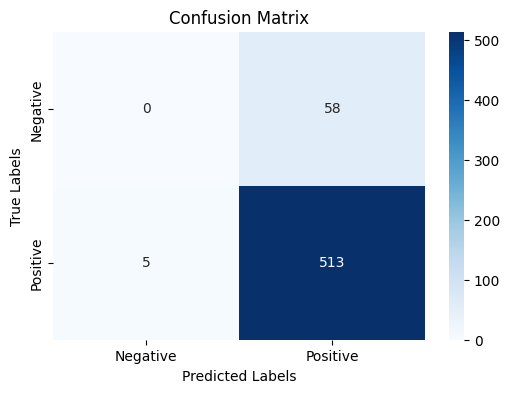

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
